In [1]:
!pip install tensorflow keras tensorflow_datasets matplotlib numpy

In [6]:
pip install tensorflow_datasets

  Using cached tensorflow_datasets-4.6.0-py3-none-any.whl (4.3 MB)
  Using cached tensorflow_metadata-1.9.0-py3-none-any.whl (51 kB)
  Using cached promise-2.3-py3-none-any.whl
  Using cached etils-0.6.0-py3-none-any.whl (98 kB)
  Using cached dill-0.3.5.1-py2.py3-none-any.whl (95 kB)
  Using cached importlib_resources-5.8.0-py3-none-any.whl (28 kB)
  Using cached googleapis_common_protos-1.56.3-py2.py3-none-any.whl (211 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [36]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [3]:
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='~\\tensorflow_datasets\\oxford_iiit_pet\\3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling

In [4]:
### resize image 
def resize(input_image ,input_mask):
    input_image = tf.image.resize(input_image,(128,128),method = 'nearest')
    input_mask  = tf.image.resize(input_mask,(128,128),method='nearest')
    return input_image ,input_mask


#horizantal agumentin 
def agument(input_image, input_mask):
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)
    return input_image, input_mask


#image Normalizasyon
def normalize(input_image,input_mask):
    input_image = tf.cast(input_image, tf.float32) /255.0
    input_mask -= 1
    return input_image, input_mask


#dataset train için resize,agumantion, normalize uygulanması
def load_image_train(datapoint):
    input_image =datapoint['image']
    input_mask = datapoint['segmentation_mask']
    input_image , input_mask = resize(input_image , input_mask)
    input_image , input_mask = agument(input_image , input_mask)
    input_image , input_mask = normalize(input_image , input_mask)
    return input_image ,input_mask


#test için resiz ve normalize işlemleri  , Agumentin uygulanmıyor
def load_image_test(datapoint):
    input_image =datapoint['image']
    input_mask = datapoint['segmentation_mask']
    input_image , input_mask = resize(input_image , input_mask)
    input_image , input_mask = normalize(input_image , input_mask)
    return input_image ,input_mask



In [6]:
train_dataset = dataset['train'].map(load_image_train ,
                                     num_parallel_calls = tf.data.AUTOTUNE)

test_dataset = dataset['test'].map(load_image_test ,
                                     num_parallel_calls = tf.data.AUTOTUNE)#TENSORFLOW PERFORMANS AYARI

In [7]:
#128,128,3 olarak alınana dataset 128,128,1 yani renkliden siyah beyaza cevriliyor
print(train_dataset)

<ParallelMapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))>


In [8]:
BATCH_SIZE=64
BUFFER_SIZE =1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

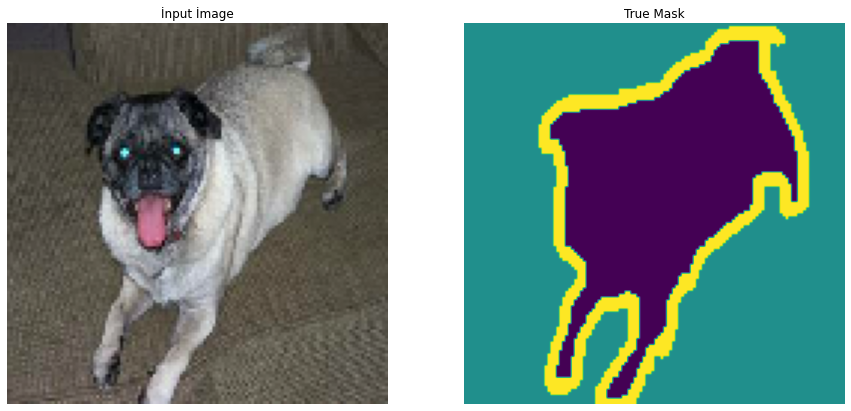

In [33]:
### Örnek gösterim
def example(example_list):
    plt.figure(figsize=(15,15))
    title= ['İnput İmage','True Mask','Predict Mask']
    for i in range(len(example_list)):
        plt.subplot(1 , len(example_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(example_list[i]))
        plt.axis('off')
    plt.show()

sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index],sample_batch[1][random_index]


example([sample_image , sample_mask])

    

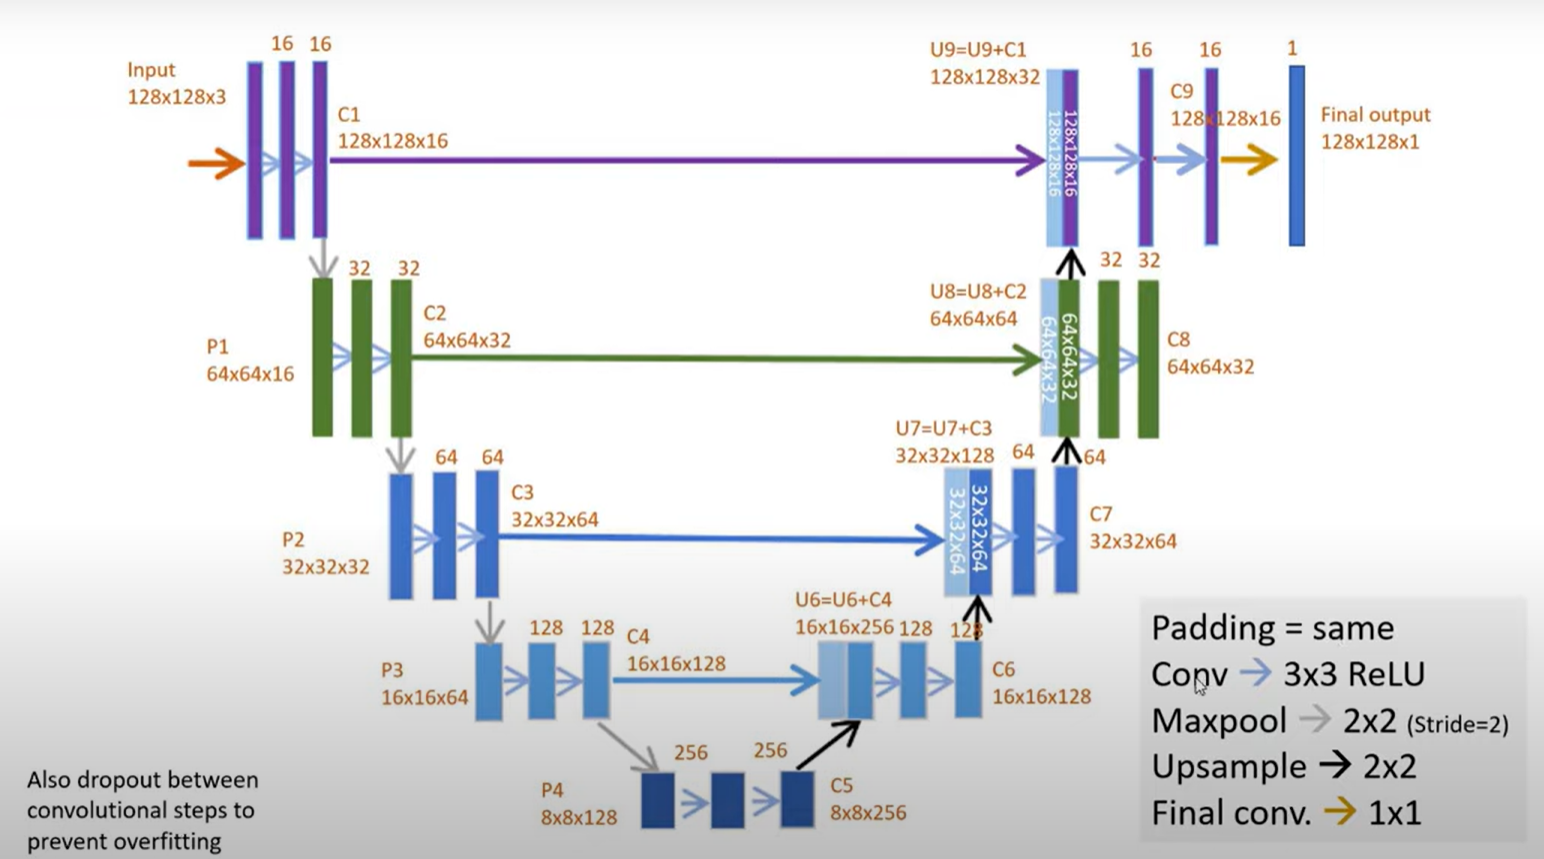

In [29]:
#Unet Model Oluşturma

img_width = 128
img_height = 128
img_channels = 3

inputs = tf.keras.layers.Input((img_width,img_height,img_channels))

s = tf.keras.layers.Lambda(lambda x:x/255)(inputs)
#down layer
l1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu' ,kernel_initializer='he_normal' ,padding = 'same')(s)
l1 = tf.keras.layers.Dropout(0.3)(l1)
l1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu' ,kernel_initializer='he_normal' ,padding = 'same')(l1)
p1 = tf.keras.layers.MaxPool2D(2)(l1)

l2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu' ,kernel_initializer='he_normal' ,padding = 'same')(p1)
l2 = tf.keras.layers.Dropout(0.3)(l2)
l2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu' ,kernel_initializer='he_normal' ,padding = 'same')(l2)
p2 = tf.keras.layers.MaxPool2D(2)(l2)


l3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu' ,kernel_initializer='he_normal' ,padding = 'same')(p2)
l3 = tf.keras.layers.Dropout(0.3)(l3)
l3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu' ,kernel_initializer='he_normal' ,padding = 'same')(l3)
p3 = tf.keras.layers.MaxPool2D(2)(l3)

l4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu' ,kernel_initializer='he_normal' ,padding = 'same')(p3)
l4 = tf.keras.layers.Dropout(0.3)(l4)
l4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu' ,kernel_initializer='he_normal' ,padding = 'same')(l4)
p4 = tf.keras.layers.MaxPool2D(pool_size=(2))(l4)

l5 = tf.keras.layers.Conv2D(256,(3,3),activation='relu' ,kernel_initializer='he_normal' ,padding = 'same')(p4)
l5 = tf.keras.layers.Dropout(0.3)(l5)
l5 = tf.keras.layers.Conv2D(256,(3,3),activation='relu' ,kernel_initializer='he_normal' ,padding = 'same')(l5)

#Up Layer
#aradaki birleştirme
c6 = tf.keras.layers.Conv2DTranspose(128,(2,2), strides=(2,2), padding = 'same')(l5)
c6 = tf.keras.layers.concatenate([c6, l4])
l6 = tf.keras.layers.Conv2D(128,(3,3),activation='relu' ,kernel_initializer='he_normal' ,padding = 'same')(c6)
l6 = tf.keras.layers.Dropout(0.3)(l6)
l6 = tf.keras.layers.Conv2D(128,(3,3),activation='relu' ,kernel_initializer='he_normal' ,padding = 'same')(l6)


c7 = tf.keras.layers.Conv2DTranspose(64,(2,2), strides=(2,2), padding = 'same')(l6)
c7 = tf.keras.layers.concatenate([c7, l3])
l7= tf.keras.layers.Conv2D(64,(3,3),activation='relu' ,kernel_initializer='he_normal' ,padding = 'same')(c7)
l7= tf.keras.layers.Dropout(0.3)(l7)
l7 = tf.keras.layers.Conv2D(64,(3,3),activation='relu' ,kernel_initializer='he_normal' ,padding = 'same')(l7)

c8 = tf.keras.layers.Conv2DTranspose(32,(2,2), strides=(2,2), padding = 'same')(l7)
c8 = tf.keras.layers.concatenate([c8, l2])
l8= tf.keras.layers.Conv2D(32,(3,3),activation='relu' ,kernel_initializer='he_normal' ,padding = 'same')(c8)
l8= tf.keras.layers.Dropout(0.3)(l8)
l8= tf.keras.layers.Conv2D(32,(3,3), activation='relu' , kernel_initializer='he_normal' ,padding = 'same')(l8)


c9 = tf.keras.layers.Conv2DTranspose(16,(2,2), strides=(2,2), padding = 'same')(l8)
c9 = tf.keras.layers.concatenate([c9, l1])
l9= tf.keras.layers.Conv2D(16,(3,3),activation='relu' ,kernel_initializer='he_normal' ,padding = 'same')(c9)
l9= tf.keras.layers.Dropout(0.3)(l9)
l9= tf.keras.layers.Conv2D(16,(3,3),activation='relu' ,kernel_initializer='he_normal' ,padding = 'same')(l9)

outputs = tf.keras.layers.Conv2D(3, 1, padding="same", activation = "softmax")(l9)


model = tf.keras.Model(inputs = [inputs] , outputs = [outputs])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()



Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_3 (Lambda)              (None, 128, 128, 3)  0           ['input_11[0][0]']               
                                                                                                  
 conv2d_136 (Conv2D)            (None, 128, 128, 16  448         ['lambda_3[0][0]']               
                                )                                                                 
                                                                                            

 conv2d_150 (Conv2D)            (None, 64, 64, 32)   18464       ['concatenate_28[0][0]']         
                                                                                                  
 dropout_74 (Dropout)           (None, 64, 64, 32)   0           ['conv2d_150[0][0]']             
                                                                                                  
 conv2d_151 (Conv2D)            (None, 64, 64, 32)   9248        ['dropout_74[0][0]']             
                                                                                                  
 conv2d_transpose_29 (Conv2DTra  (None, 128, 128, 16  2064       ['conv2d_151[0][0]']             
 nspose)                        )                                                                 
                                                                                                  
 concatenate_29 (Concatenate)   (None, 128, 128, 32  0           ['conv2d_transpose_29[0][0]',    
          

In [30]:
EPOCHS = 20
train_len = info.splits['train'].num_examples
steps_per_epoch = train_len // BATCH_SIZE

val_subsplits = 5
test_len = info.splits['test'].num_examples
validation_step = test_len // BATCH_SIZE//val_subsplits


history = model.fit(train_batches,
                   epochs = EPOCHS,
                   steps_per_epoch = steps_per_epoch,
                   validation_steps = validation_step,
                   validation_data = test_batches)

Epoch 1/20
57/57 [==============================] - 212s 4s/step - loss: 0.9654 - accuracy: 0.5859 - val_loss: 0.8693 - val_accuracy: 0.5864
Epoch 2/20
57/57 [==============================] - 184s 3s/step - loss: 0.8109 - accuracy: 0.6583 - val_loss: 0.7949 - val_accuracy: 0.6811
Epoch 3/20
57/57 [==============================] - 178s 3s/step - loss: 0.7697 - accuracy: 0.6947 - val_loss: 0.7649 - val_accuracy: 0.6976
Epoch 4/20
57/57 [==============================] - 175s 3s/step - loss: 0.7565 - accuracy: 0.6992 - val_loss: 0.7654 - val_accuracy: 0.6931
Epoch 5/20
57/57 [==============================] - 175s 3s/step - loss: 0.7527 - accuracy: 0.6994 - val_loss: 0.7548 - val_accuracy: 0.6976
Epoch 6/20
57/57 [==============================] - 176s 3s/step - loss: 0.7512 - accuracy: 0.6997 - val_loss: 0.7530 - val_accuracy: 0.6980
Epoch 7/20
57/57 [==============================] - 177s 3s/step - loss: 0.7414 - accuracy: 0.7034 - val_loss: 0.7380 - val_accuracy: 0.7009
Epoch 8/20
57

In [37]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            example([image[0], mask[0], create_mask(pred_mask)])
    else:
            example([sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))])
count = 0
for i in test_batches:
    count +=1
print("number of batches:", count)

number of batches: 11


2/2 [==============================] - 1s 443ms/step


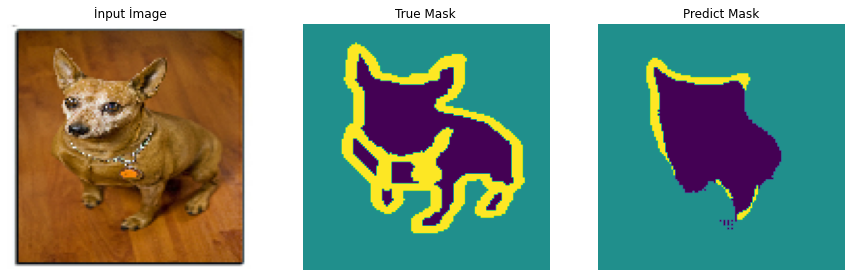

2/2 [==============================] - 1s 490ms/step


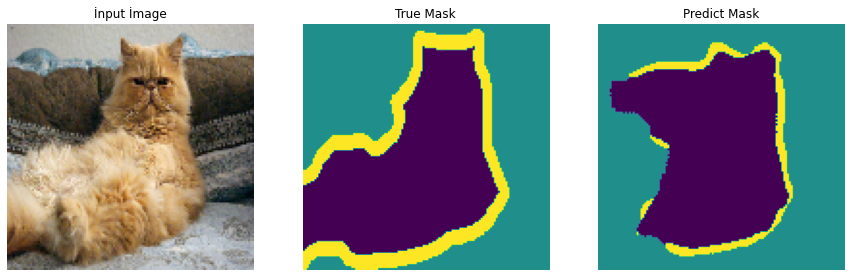

2/2 [==============================] - 1s 473ms/step


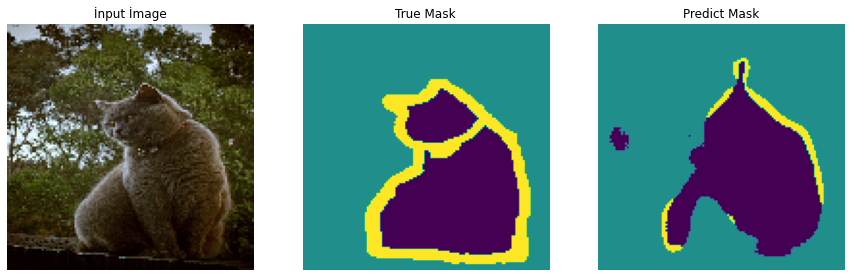

2/2 [==============================] - 1s 459ms/step


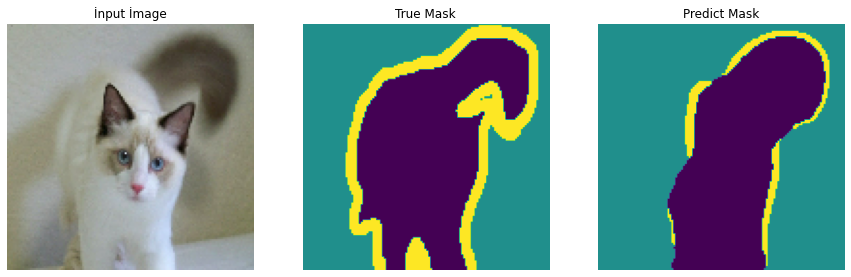

2/2 [==============================] - 1s 429ms/step


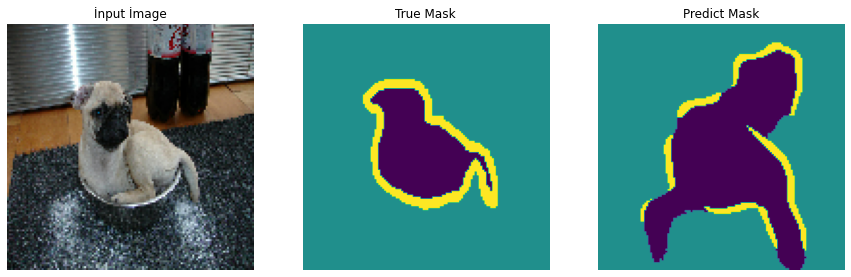

In [42]:
show_predictions(test_batches, 5)